## Sequential FDP with proxy models

#### Load modules

In [1]:
%load_ext autoreload
%autoreload 2

import os.path
import pickle

from sampler import DataSampling
from proxymodel import ProxyModel
from optimization import GlobalOpt
from utils import load_matfile
import argparse
import torch

#### Set parameters

In [5]:
parser = argparse.ArgumentParser()

args, unknown = parser.parse_known_args()

args.filepath = 'data'
args.simulation_directory = 'simulation'
args.save_directory = 'variables'
args.ecl_filename = '2D_JY_Eclrun'
args.frs_filename = '2D_JY_Frsrun'
args.perm_filename = '2D_PERMX'
args.position_filename = '2D_POSITION'
args.constraint_filename = '2D_CONSTRAINT'

args.independent_area = 40  # acre
args.num_of_x = 60
args.num_of_y = 60
args.num_of_z = 1
args.num_of_max_well = 14
args.num_of_rigs = 3
args.num_of_particles = 3
args.length_of_x = 120
args.length_of_y = 120
args.length_of_z = 120
args.num_of_ensemble = 10

args.discount_rate = 0.1
args.observed_term = 30
args.discount_term = 365
args.oil_price = 60
args.injection_cost = -5
args.disposal_cost = -3
args.drilling_cost = 0

args.production_time = 7200
args.tstep = 30
args.dstep = 90  # drilling span
args.streamline_time = 30
args.max_tof = 10000
args.max_pressure = 3500

args.num_of_train_sample = 500
args.train_ratio = 0.7
args.validate_ratio = 0.15
args.train_model_saved_dir = './model/1'
args.span_of_retrain = 20

args.ratio_of_infeasible = 0.3
args.well_type = {'P': 1, 'No': 0, 'I': -1}
args.type_fix = False
args.drilling_time_fix = True
args.location_fix = True
args.control_fix = True

args.well_placement_optimization = True
args.well_operation_optimization = True
args.simultaneous_optimization = False
args.well_location_index = None
args.well_type_real = None
args.well_placement_wset = [1500, 1500, 5500, 5500]
args.well_operation_wset = [1500, 2500, 4500, 6000]

args.perm_mat = './data/PERMX.mat'

args.parallel = True

args.cached_dir = './cached'
args.well_placement_sample_file = 'sample_wp(5).pkl'
args.well_operation_sample_file = 'sample_wo(5).pkl'
args.num_of_epochs = 20
args.batch_size = 150

args.optimization_algorithm = 'PSO'
args.num_of_generations = 200

args.gen_of_retrain = range(args.span_of_retrain, args.num_of_generations + 1, args.span_of_retrain)

assert args.validate_ratio != 0, 'validate_ratio should be greater than 0'
assert (1 - args.train_ratio - args.validate_ratio) > 0, '(train_ratio + validate_ratio) should not be 1'
if args.well_operation_optimization and not args.well_placement_optimization:
    # if you only want to optimize well operation conditions, provide well position settings by yourself
    assert args.well_placement_optimization, 'if you only want to optimize well operation conditions, provide ' \
                                             'well position settings by yourself. You must set the default well ' \
                                             'locations for a defined number of wells. ' \
                                             '- well_location_index, well_type_real'

In [6]:
if not os.path.exists(args.train_model_saved_dir):
    print('model_saved_dir not exists')
    os.mkdir(args.train_model_saved_dir)

perm = load_matfile(args.perm_mat, 'original')
perm_idx = load_matfile(args.perm_mat, 'selected')

### 1. Well placement


#### 1.1. Proxy modeling


##### make samples to train a proxy model

In [ ]:
args.independent_area = 40
args.num_of_train_sample = 500
args.well_placement_wset = [1500, 1500, 5500, 5500]
args.well_type = {'P': 1, 'No': 0, 'I': -1}
args.ratio_of_infeasible = 0.3

In [25]:
PlacementSample = DataSampling(args, wset=args.well_placement_wset, well_type=args.well_type,
                                       location_fix=False, type_fix=False, drilling_time_fix=True,
                                       control_fix=True, num_of_ensemble=args.num_of_ensemble,
                                       num_of_wells=args.num_of_max_well)

if os.path.exists(os.path.join(args.cached_dir, args.well_placement_sample_file)):
    with open(os.path.join(args.cached_dir, args.well_placement_sample_file), 'rb') as f:
        samples_p = pickle.load(f)
else:
    samples_p = []
    for idx in range(args.num_of_ensemble):
        print(f'ensemble #{idx + 1}')
        initial_p = PlacementSample.make_candidate_solutions(num_of_candidates=args.num_of_train_sample)
        samples_p += PlacementSample.make_train_data(initial_p, [perm[perm_idx[idx][0] - 1]])
    with open(os.path.join(args.cached_dir, args.well_placement_sample_file), 'wb') as f:
        pickle.dump(samples_p, f)


ensemble #1


now simulate: 100%|██████████| 500/500 [19:37<00:00,  2.36s/it]


ensemble #2


now simulate: 100%|██████████| 500/500 [20:00<00:00,  2.40s/it]


ensemble #3


now simulate: 100%|██████████| 500/500 [19:25<00:00,  2.33s/it]


ensemble #4


now simulate: 100%|██████████| 500/500 [19:07<00:00,  2.29s/it]


ensemble #5


now simulate: 100%|██████████| 500/500 [19:25<00:00,  2.33s/it]


ensemble #6


now simulate: 100%|██████████| 500/500 [19:30<00:00,  2.34s/it]


ensemble #7


now simulate: 100%|██████████| 500/500 [19:56<00:00,  2.39s/it]


ensemble #8


now simulate: 100%|██████████| 500/500 [19:53<00:00,  2.39s/it]


ensemble #9


now simulate: 100%|██████████| 500/500 [19:54<00:00,  2.39s/it]


ensemble #10


now simulate: 100%|██████████| 500/500 [19:55<00:00,  2.39s/it]


##### NPV histogram

(array([ 141.,  329.,  639.,  924., 1089.,  949.,  576.,  260.,   80.,
          13.]),
 array([-1.36391438e+07,  3.30249767e+07,  7.96890972e+07,  1.26353218e+08,
         1.73017338e+08,  2.19681459e+08,  2.66345579e+08,  3.13009700e+08,
         3.59673820e+08,  4.06337941e+08,  4.53002061e+08]),
 <BarContainer object of 10 artists>)

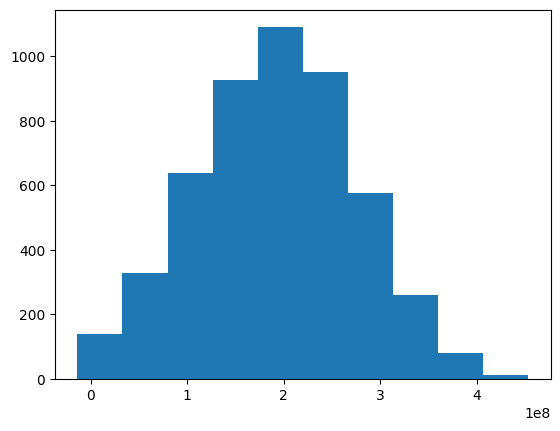

In [27]:
from matplotlib import pyplot
pyplot.hist([s.fit for s in samples_p])

##### train a proxy model

In [ ]:
args.train_ratio = 0.7
args.validate_ratio = 0.15
args.train_model_saved_dir = './model/1'

args.num_of_epochs = 20
args.batch_size = 150
model_name = 'ResNet'

In [31]:
Model_p = ProxyModel(args, samples_p, model_name=model_name)
if os.path.exists(f'{Model_p.saved_dir}/saved_model.pth'):
    Model_p.model.load_state_dict(torch.load(f'{Model_p.saved_dir}/saved_model.pth'))
else:
    Model_p.model = Model_p.train_model(samples_p, train_ratio=args.train_ratio,
                                        validate_ratio=args.validate_ratio,
                                        saved_dir=Model_p.saved_dir)

epoch: 0 - loss: 1.0836532314618428 :   5%|▌         | 1/20 [00:29<09:20, 29.47s/it]

Epoch 1 		 Training Loss: 1.0836532314618428 		 Validation Loss: 0.6493516683578491
Validation Loss Decreased(inf--->0.649352) 	 Saving The Model


epoch: 1 - loss: 0.4653758021692435 :  10%|█         | 2/20 [01:00<09:03, 30.21s/it]

Epoch 2 		 Training Loss: 0.4653758021692435 		 Validation Loss: 0.5301491141319274
Validation Loss Decreased(0.649352--->0.530149) 	 Saving The Model


epoch: 2 - loss: 0.36024082203706104 :  15%|█▌        | 3/20 [01:30<08:36, 30.36s/it]

Epoch 3 		 Training Loss: 0.36024082203706104 		 Validation Loss: 0.3808392107486725
Validation Loss Decreased(0.530149--->0.380839) 	 Saving The Model


epoch: 3 - loss: 0.35385386645793915 :  20%|██        | 4/20 [02:01<08:10, 30.64s/it]

Epoch 4 		 Training Loss: 0.35385386645793915 		 Validation Loss: 0.32929704189300535
Validation Loss Decreased(0.380839--->0.329297) 	 Saving The Model


epoch: 4 - loss: 0.31030213584502536 :  25%|██▌       | 5/20 [02:32<07:38, 30.58s/it]

Epoch 5 		 Training Loss: 0.31030213584502536 		 Validation Loss: 0.36387556195259096


epoch: 5 - loss: 0.2868207624802987 :  30%|███       | 6/20 [03:03<07:10, 30.74s/it] 

Epoch 6 		 Training Loss: 0.2868207624802987 		 Validation Loss: 0.3584774315357208


epoch: 6 - loss: 0.31911162721614045 :  35%|███▌      | 7/20 [03:36<06:48, 31.39s/it]

Epoch 7 		 Training Loss: 0.31911162721614045 		 Validation Loss: 0.4762783646583557


epoch: 7 - loss: 0.32853849418461323 :  40%|████      | 8/20 [04:06<06:12, 31.03s/it]

Epoch 8 		 Training Loss: 0.32853849418461323 		 Validation Loss: 0.3097278118133545
Validation Loss Decreased(0.329297--->0.309728) 	 Saving The Model


epoch: 8 - loss: 0.2587418823192517 :  45%|████▌     | 9/20 [04:36<05:39, 30.87s/it] 

Epoch 9 		 Training Loss: 0.2587418823192517 		 Validation Loss: 0.47186166048049927


epoch: 9 - loss: 0.23142423232396445 :  50%|█████     | 10/20 [05:06<05:05, 30.55s/it]

Epoch 10 		 Training Loss: 0.23142423232396445 		 Validation Loss: 0.35935882329940794


epoch: 10 - loss: 0.24038346173862615 :  55%|█████▌    | 11/20 [05:39<04:40, 31.15s/it]

Epoch 11 		 Training Loss: 0.24038346173862615 		 Validation Loss: 0.5469210147857666


epoch: 11 - loss: 0.24526510884364447 :  60%|██████    | 12/20 [06:08<04:05, 30.69s/it]

Epoch 12 		 Training Loss: 0.24526510884364447 		 Validation Loss: 0.29017109870910646
Validation Loss Decreased(0.309728--->0.290171) 	 Saving The Model


epoch: 12 - loss: 0.22903596051037312 :  65%|██████▌   | 13/20 [06:38<03:33, 30.46s/it]

Epoch 13 		 Training Loss: 0.22903596051037312 		 Validation Loss: 0.2947544872760773


epoch: 13 - loss: 0.24340412889917692 :  70%|███████   | 14/20 [07:07<03:00, 30.05s/it]

Epoch 14 		 Training Loss: 0.24340412889917692 		 Validation Loss: 0.3687399923801422


epoch: 14 - loss: 0.2759851614634196 :  75%|███████▌  | 15/20 [07:34<02:25, 29.05s/it] 

Epoch 15 		 Training Loss: 0.2759851614634196 		 Validation Loss: 0.4348774075508118


epoch: 15 - loss: 0.24715564089516798 :  80%|████████  | 16/20 [08:05<01:58, 29.52s/it]

Epoch 16 		 Training Loss: 0.24715564089516798 		 Validation Loss: 0.4400239050388336


epoch: 16 - loss: 0.20500652740399042 :  85%|████████▌ | 17/20 [08:38<01:31, 30.61s/it]

Epoch 17 		 Training Loss: 0.20500652740399042 		 Validation Loss: 0.28018840551376345
Validation Loss Decreased(0.290171--->0.280188) 	 Saving The Model


epoch: 17 - loss: 0.24554882322748503 :  90%|█████████ | 18/20 [09:09<01:01, 30.76s/it]

Epoch 18 		 Training Loss: 0.24554882322748503 		 Validation Loss: 0.3322198331356049


epoch: 18 - loss: 0.22236529178917408 :  95%|█████████▌| 19/20 [09:40<00:30, 30.71s/it]

Epoch 19 		 Training Loss: 0.22236529178917408 		 Validation Loss: 0.2584627240896225
Validation Loss Decreased(0.280188--->0.258463) 	 Saving The Model


epoch: 19 - loss: 0.18955818998316923 : 100%|██████████| 20/20 [10:10<00:00, 30.53s/it]

Epoch 20 		 Training Loss: 0.18955818998316923 		 Validation Loss: 0.3384425282478333
Now test to test_dataset


[0.9270236724296214]


##### plot "real-prediction"

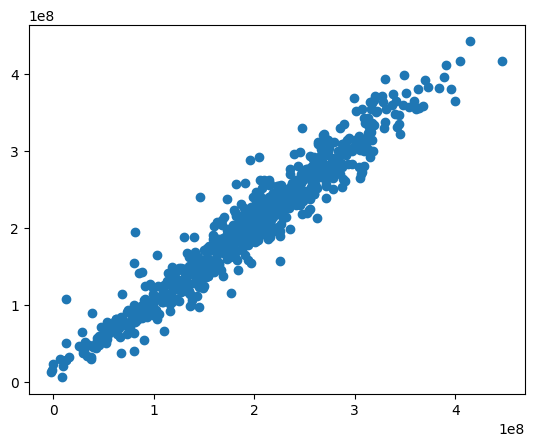

In [33]:
from matplotlib import pyplot
real = Model_p.reals
prediction = Model_p.predictions
pyplot.scatter(real, prediction)


#### 1.2. Optimization


In [34]:
args.optimization_algorithm = 'PSO'
args.num_of_generations = 10

In [56]:
placement_positions = PlacementSample.make_candidate_solutions(num_of_candidates=args.num_of_particles)

WPO = GlobalOpt(args, placement_positions, [PlacementSample.perm[idx[0]-1] for idx in PlacementSample.perm_idx],
                alg_name='PSO', nn_model=Model_p, sample=samples_p)
WPO.iterate(args.num_of_generations)
best_wp = WPO.get_solution(location=True, type=True)

best fit = 64183124.0: 100%|██████████| 10/10 [04:06<00:00, 24.64s/it]


### 2. Well operation


#### 2.1. Proxy modeling

##### make samples to train a proxy model


In [57]:
OperationSample = DataSampling(args, wset=args.well_operation_wset, well_type=args.well_type,
                                       type_fix=True, location_fix=True, drilling_time_fix=False,
                                       control_fix=False, num_of_ensemble=args.num_of_ensemble,
                                       num_of_wells=len(best_wp['location']), violation_check=False)

if os.path.exists(os.path.join(args.cached_dir, args.well_operation_sample_file)):
    with open(args.cached_file, 'rb') as f:
        samples_o = pickle.load(f)
else:
    args.drilling_cost = 2E+06
    initial_o = OperationSample.make_candidate_solutions(num_of_candidates=args.num_of_train_sample,
                                                         location=best_wp['location'],
                                                         type_real=best_wp['type'])
    samples_o = OperationSample.make_train_data(initial_o, [perm[idx[0] - 1] for idx in perm_idx],
                                                use_frontsim=False)
    with open(os.path.join(args.cached_dir, args.well_operation_sample_file), 'wb') as f:
        pickle.dump(samples_o, f)

now simulate: 100%|██████████| 500/500 [2:38:09<00:00, 18.98s/it]  


##### NPV histogram

(array([  1.,   3.,   9.,  28.,  63., 111., 159.,  93.,  28.,   5.]),
 array([3.44709457e+08, 3.49499842e+08, 3.54290228e+08, 3.59080613e+08,
        3.63870998e+08, 3.68661384e+08, 3.73451769e+08, 3.78242154e+08,
        3.83032539e+08, 3.87822925e+08, 3.92613310e+08]),
 <BarContainer object of 10 artists>)

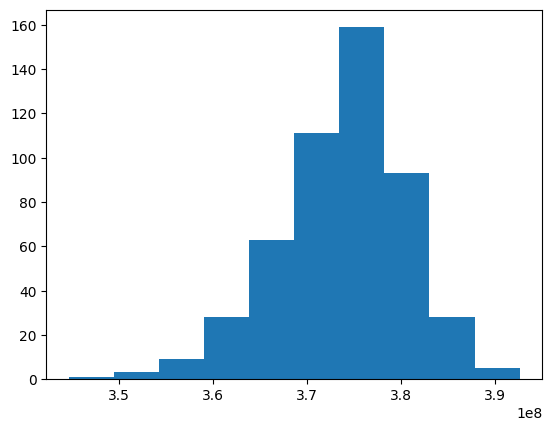

In [58]:
from matplotlib import pyplot
pyplot.hist([s.fit for s in samples_o])

##### train a proxy model

In [71]:
Model_o = ProxyModel(args, samples_o, model_name='LSTM')
if os.path.exists(f'{Model_o.saved_dir}/saved_model.pth'):
    Model_o.model.load_state_dict(torch.load(f'{Model_o.saved_dir}/saved_model.pth'))
else:
    Model_o.model = Model_o.train_model(samples_o, train_ratio=args.train_ratio,
                                        validate_ratio=args.validate_ratio,
                                        saved_dir=Model_o.saved_dir)

ValueError: could not convert string to float: ''

#### 2.2. Optimization


In [ ]:
operation_positions = OperationSample.make_candidate_solutions(num_of_candidates=args.num_of_particles)

WOO = GlobalOpt(args, operation_positions, OperationSample.perm[:, OperationSample.perm_idx - 1],
                alg_name='PSO', nn_model=Model_o, sample=samples_p)
WOO.iterate(args.num_of_generations)
best_wo = WOO.get_solution(drilling_time=True, control=True)